In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

import warnings # Supress warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("./files/interpolated_w.csv", index_col=0)
df.index = pd.to_datetime(df.index, format = '%Y-%m-%d')
num = 20


df

,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
Date,,,,,
2009-01-11,0.9,-30.934286,1.914286,-212164.704,2.314286
2009-01-18,1.2,-30.598571,5.485714,-196624.800,2.300000
2009-01-25,4.2,-30.130000,8.585714,-162883.872,2.357143
2009-02-01,0.0,-29.907143,4.728571,-171409.824,2.571429
2009-02-08,10.4,-29.608571,8.671429,-179798.400,2.628571
...,...,...,...,...,...
2020-05-31,22.2,-24.761429,16.885714,-183938.688,2.414286
2020-06-07,19.6,-24.652857,19.271429,-179465.760,2.442857
2020-06-14,43.0,-24.724286,18.428571,-180633.888,2.771429


In [ ]:
features_cos = ['Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry', 'day_cos', 'month_cos', 'week_of_year_cos', 'quarter_cos', 'season_cos']
delete2 = [feature for feature in df.columns if feature not in features_cos]
df_cos = df.drop(delete2, axis=1)
features_new = ['Depth_to_Groundwater', 'Drainage_Volume', 'River_Hydrometry']
delete3 = [feature for feature in df_cos.columns if feature not in features_new]
df = df_cos.drop(delete3, axis=1)

In [36]:
target = ['Depth_to_Groundwater']
#features = [feature for feature in df.columns if feature not in target]
features = ['Drainage_Volume', 'River_Hydrometry']

In [37]:
features

['Drainage_Volume', 'River_Hydrometry']

In [38]:
def split_data():
    testSize = int(0.3 * len(df))
    train= df.iloc[:-testSize]
    test= df.iloc[-testSize:]
    return train, test
train, test = split_data()

In [39]:
testSize = int(0.3 * len(df))
testSize

179

In [40]:
# Find the optimal ARIMAX model order using auto_arima
auto_model = auto_arima(
    train[target],
    exogenous=train[features],
    seasonal=False,  # Set to True for seasonal data
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore",
    max_order=None,  # You can limit the search space for orders
    trace=True
)

# Get the selected order
order = auto_model.order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-553.371, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-211.823, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-513.343, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-393.623, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-210.287, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-552.397, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-551.437, Time=0.32 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-553.158, Time=0.52 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-553.383, Time=0.59 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-555.382, Time=0.35 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-472.816, Time=0.21 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-553.383, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-434.197, Time=0.26 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-494.608, Time=0.33 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept

In [24]:
order

(1, 1, 3)

In [25]:
#open text file
text_file = open("C:\\Users\\poeppelmann\\DataspellProjects\\dsProject\\order\\ARIMAX_order_"+str(num)+".txt", "w")

#write string to file
text_file.write(str(order))

#close file
text_file.close()

In [26]:
def fit_arimax(df):
    model = ARIMA(endog=df[target], exog=df[features], order=order)
    model=model.fit()
    return model

In [16]:
model = fit_arimax(train)
predictions = model.predict(start=test.index[0], end=test.index[-1], exog=test[features])

<Axes: xlabel='Date'>

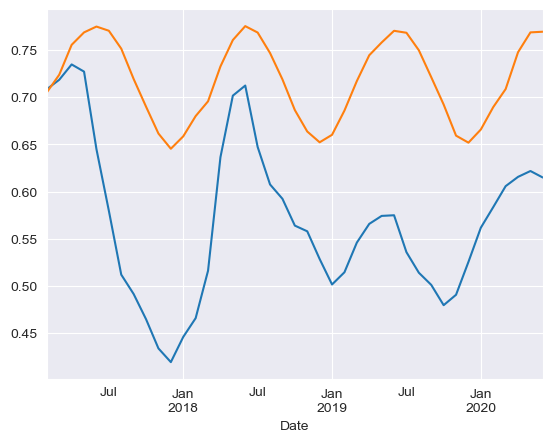

In [18]:

test['Depth_to_Groundwater'].plot(label=True)
predictions.plot(label=True)

In [41]:
# Rolling ARIMA algorithm
def arimax_roll():
    history = train.copy()
    predictions = pd.Series()

    for t in range(len(test)):
        model = fit_arimax(history)
        hat = model.forecast(steps=1, exog=history[features].iloc[[-1]])  # Forecast one step ahead
        predictions = predictions.append(hat)

        # Update history and exogenous history for the next iteration
        history = history.append(test.iloc[t])
    return predictions

In [42]:
predictions = arimax_roll()

In [43]:
predictions

2017-01-29   -23.722293
2017-02-05   -23.584815
2017-02-12   -23.454369
2017-02-19   -23.504875
2017-02-26   -23.503332
                ...    
2020-05-31   -24.670281
2020-06-07   -24.753420
2020-06-14   -24.600879
2020-06-21   -24.735046
2020-06-28   -24.735310
Freq: W-SUN, Length: 179, dtype: float64

<Axes: xlabel='Date'>

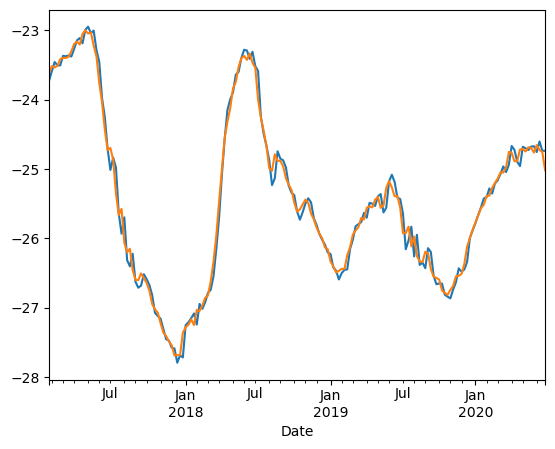

In [44]:
predictions.plot()
test['Depth_to_Groundwater'].plot()

In [45]:
predictions.name = 'Depth_to_Groundwater'
predictions.to_csv('predictions/ARIMAX/'+str(num)+'.csv')

In [46]:
saved_sr = pd.read_csv('./predictions/ARIMA/'+str(num)+'.csv', index_col=0)
saved_sr.index = pd.to_datetime(saved_sr.index, format = '%Y-%m-%d')

FileNotFoundError: [Errno 2] No such file or directory: './predictions/ARIMA/12.csv'

In [46]:
saved_sr = predictions

In [47]:
metrics = {}
def calc_metrics():

    results = pd.DataFrame(data={'Predictions':saved_sr, 'Actuals':df['Depth_to_Groundwater']}, index=saved_sr.index)

    # Step 2: Calculate the differences between the predicted and actual values
    results['Difference'] = results['Actuals'] - results['Predictions']

    # Step 3: Calculate squared differences for RMSE
    results['Squared_difference'] = results['Difference'] ** 2

    # Step 4: Calculate absolute differences for MAE and MAPE
    results['Absolute_difference'] = np.abs(results['Difference'])
    results['Absolute_percentage_difference'] = np.abs(results['Difference'] / results['Actuals'])

    # Step 5: Compute the metrics
    rmse = np.sqrt(results['Squared_difference'].mean())
    mae = results['Absolute_difference'].mean()
    mape = results['Absolute_percentage_difference'].mean() * 100  # to get the percentage
    return rmse, mae, mape

rmse, mae, mape = calc_metrics()
metrics['Depth_to_Groundwater'] = {
    'RMSE': rmse,
    'MAE': mae,
    'MAPE': mape
}
metrics_df = pd.DataFrame(metrics)

In [48]:
metrics_df

,Depth_to_Groundwater
MAE,0.100525
MAPE,0.395520
RMSE,0.136102


In [17]:
metrics_df.to_csv('metrics/ARIMAX/'+str(num)+'.csv')

In [49]:
import winsound
winsound.Beep(2500,1000)